# <u>Series de Tiempo - ARIMA</u>

### Importando librería para predicción con series de tiempo

In [120]:
!py -3.10 -m pip install pmdarima


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
import warnings
warnings.filterwarnings("ignore")
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from math import sqrt

import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

### Importando Data
- Dataset: Pasajeros de aerolínea
- Unidad: Miles

In [122]:
#Importamos la data
csv = 'SalesDemand.csv'
df = pd.read_csv(csv,delimiter=";")

In [123]:
df=df.dropna()
df

,date,store,item,sales
0,1/01/2013,1.0,1.0,13.0
1,2/01/2013,1.0,1.0,11.0
2,3/01/2013,1.0,1.0,14.0
3,4/01/2013,1.0,1.0,13.0
4,5/01/2013,1.0,1.0,10.0
...,...,...,...,...
912995,27/12/2017,10.0,50.0,63.0
912996,28/12/2017,10.0,50.0,59.0
912997,29/12/2017,10.0,50.0,74.0
912998,30/12/2017,10.0,50.0,62.0


In [124]:
df["date"]=pd.to_datetime(df['date'], dayfirst=True)
df['month_year'] = df['date'].dt.strftime('%m/%Y')
df['month_year'] = pd.to_datetime(df['month_year'], format='%m/%Y')
df.sort_values(by='month_year', inplace=True)
df.reset_index(drop=True, inplace=True)

ventas_totales = df.groupby('month_year', as_index=False)['sales'].sum()


In [125]:
ventas_totales.describe()

,month_year,sales
count,60,6.000000e+01
mean,2015-06-16 20:48:00,7.950752e+05
min,2013-01-01 00:00:00,4.549040e+05
25%,2014-03-24 06:00:00,6.617050e+05
50%,2015-06-16 00:00:00,7.990180e+05
75%,2016-09-08 12:00:00,9.220262e+05
max,2017-12-01 00:00:00,1.171393e+06
std,NaN,1.729018e+05


In [126]:
ventas_totales.head()

,month_year,sales
0,2013-01-01,454904.0
1,2013-02-01,459417.0
2,2013-03-01,617382.0
3,2013-04-01,682274.0
4,2013-05-01,763242.0


In [127]:
print('Time period start: {}\nTime period end: {}'.format(ventas_totales["month_year"].min(),ventas_totales["month_year"].max()))

Time period start: 2013-01-01 00:00:00
Time period end: 2017-12-01 00:00:00


In [128]:
ventas_totales.shape

(60, 2)

## 1.Preprocesamiento de data y visualización

__Establecer índice como la columna de fecha y hora para manipulaciones más fáciles:__

---



In [129]:
y_ventas_totales = ventas_totales.set_index('month_year')


In [130]:
y_ventas_totales.index


DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'], dtype='datetime64[ns]', name='month_year', freq=None)

In [131]:
y_ventas_totales.head(12)


,sales
month_year,
2013-01-01,454904.0
2013-02-01,459417.0
2013-03-01,617382.0
2013-04-01,682274.0
2013-05-01,763242.0
2013-06-01,795597.0
2013-07-01,855922.0
2013-08-01,766761.0
2013-09-01,689907.0


In [132]:
y_ventas_totales.isnull().sum()

sales    0
dtype: int64

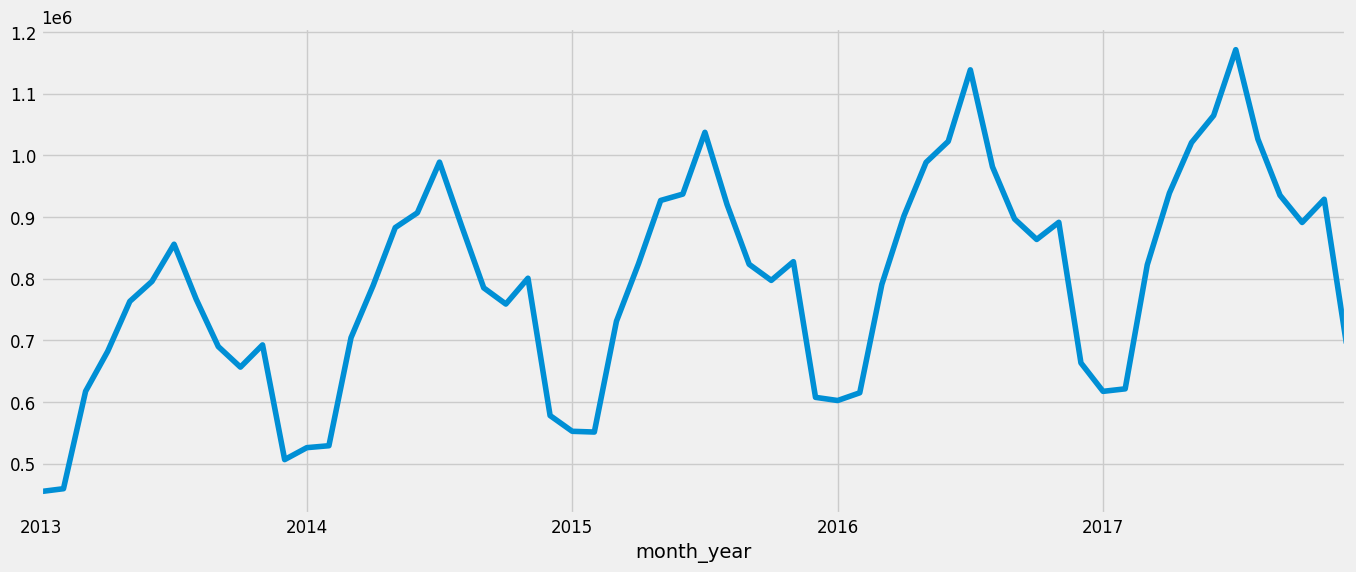

In [133]:
y_ventas_totales.sales.plot(figsize=(15, 6))
plt.show()

__Cajas y bigotes:__
- Los valores medianos a través de los años confirman una tendencia al alza
- Aumento constante de la propagación, o 50% medio de los datos (cuadros) con el tiempo
- Un modelo que considere la estacionalidad podría funcionar bien

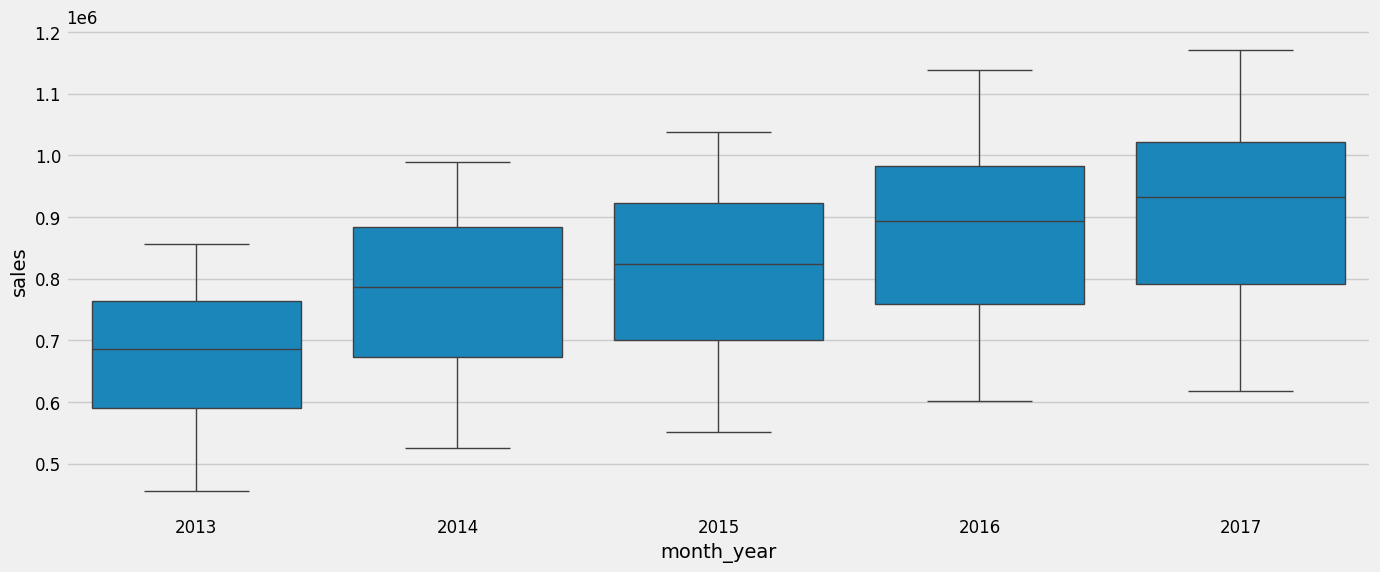

In [134]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=y_ventas_totales.sales.index.year, y=y_ventas_totales.sales)
plt.show()

### Gráficos ACF y PACF

- Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF)
- Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una __disminución rápida de la correlación__ después de una pequeña cantidad de retraso entre los puntos.
- Estos datos no son estacionarios, ya que un gran número de observaciones anteriores están correlacionadas con valores futuros.
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- La autocorrelación parcial en el retraso k es la correlación que resulta después de eliminar el efecto de cualquier correlación debido a los términos en los retrasos más cortos.

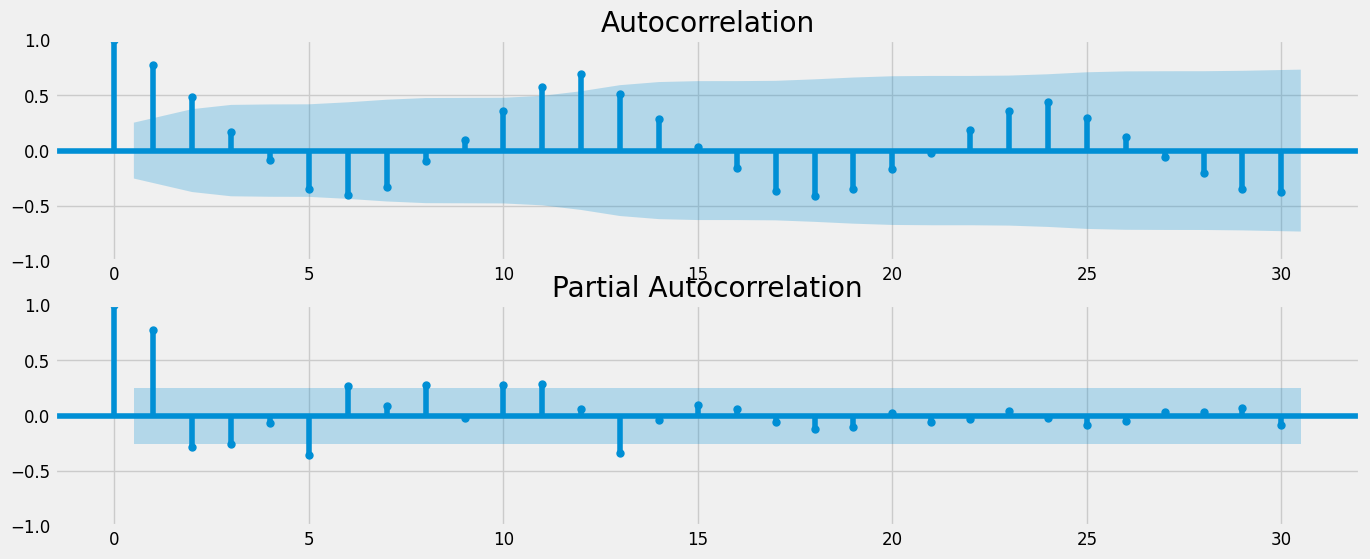

In [135]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,6))
plt.subplot(211)
plot_acf(y_ventas_totales.sales, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(y_ventas_totales.sales, ax=plt.gca(),lags=30)
plt.show()

## Hacer series temporales estacionarias
Hay 2 razones principales detrás de la no estacionaria de un TS:

1. __Trend__ - media variable con el tiempo.
2. __Estacionalidad__ - variaciones en marcos de tiempo específicos.

### Transformaciones
- Podemos aplicar transformaciones que penalizan los valores más altos más que los valores más pequeños. Estos pueden tomar un registro, raíz cuadrada, raíz cúbica, etc. Tomemos una transformación de registro aquí por simplicidad:


#### Transformación logarítmica

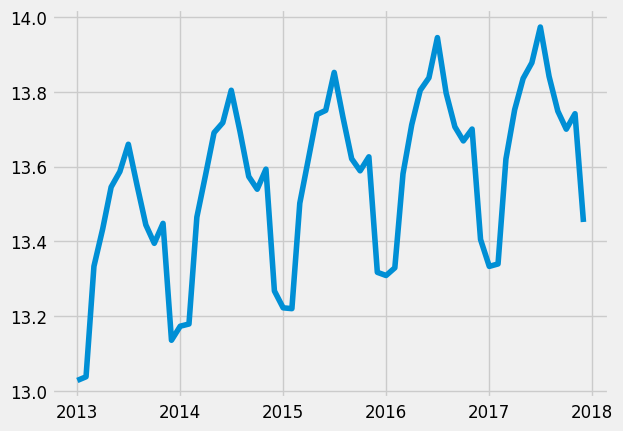

In [136]:
ts_log = np.log(y_ventas_totales)
plt.plot(ts_log)
plt.show()

#### Otras posibles transformaciones:
- Transformación exponencial
- Transformación de Box Cox
- Transformación de raíz cuadrada

### Técnicas para eliminar Tendencia - Suavizado
- Alisar es tomar promedios continuos en ventanas de tiempo

#### Media móvil
- Tomamos un promedio de "k" valores consecutivos dependiendo de la frecuencia de las series de tiempo.
- Aquí podemos tomar el promedio durante el último año, es decir, los últimos 12 valores.
- Un inconveniente de este enfoque particular es que el período de tiempo debe definirse estrictamente.

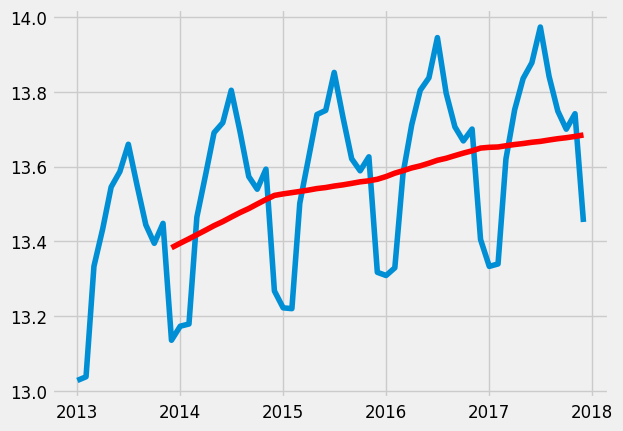

In [137]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [138]:
ts_log_moving_avg_diff = ts_log.sales - moving_avg.sales
ts_log_moving_avg_diff

month_year
2013-01-01         NaN
2013-02-01         NaN
2013-03-01         NaN
2013-04-01         NaN
2013-05-01         NaN
2013-06-01         NaN
2013-07-01         NaN
2013-08-01         NaN
2013-09-01         NaN
2013-10-01         NaN
2013-11-01         NaN
2013-12-01   -0.247585
2014-01-01   -0.222143
2014-02-01   -0.227981
2014-03-01    0.047039
2014-04-01    0.148388
2014-05-01    0.248782
2014-06-01    0.264658
2014-07-01    0.339351
2014-08-01    0.216900
2014-09-01    0.085707
2014-10-01    0.039647
2014-11-01    0.081300
2014-12-01   -0.255627
2015-01-01   -0.304907
2015-02-01   -0.310499
2015-03-01   -0.031557
2015-04-01    0.085160
2015-05-01    0.198216
2015-06-01    0.206505
2015-07-01    0.304073
2015-08-01    0.181245
2015-09-01    0.065836
2015-10-01    0.029538
2015-11-01    0.064201
2015-12-01   -0.249064
2016-01-01   -0.264758
2016-02-01   -0.253295
2016-03-01   -0.008267
2016-04-01    0.115660
2016-05-01    0.202141
2016-06-01    0.228612
2016-07-01    0.328334


### Técnicas adicionales para eliminar la estacionalidad y la tendencia
- Las técnicas simples de reducción de tendencias discutidas antes no funcionan en todos los casos, particularmente en aquellas con alta estacionalidad.

#### Diferenciación
- En esta técnica, tomamos la diferencia de la observación en un instante particular con la del instante anterior.
- Diferenciación de primer orden en pandas

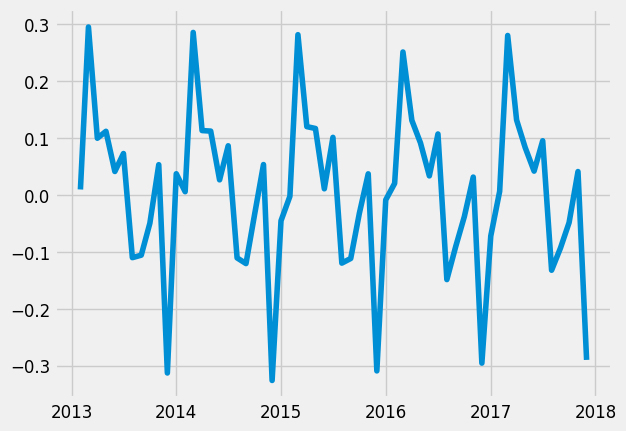

In [139]:
ts_log_diff = ts_log.sales - ts_log.sales.shift()
plt.plot(ts_log_diff)
plt.show()

# Predicción de series de tiempo

## Autoregresión (AR)
- El método de autorregresión (AR) modela el siguiente paso de la secuencia como una función lineal de las observaciones en los pasos de tiempo anteriores.
- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).

In [140]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from random import random

In [141]:
ts_log_diff = ts_log_diff.dropna()

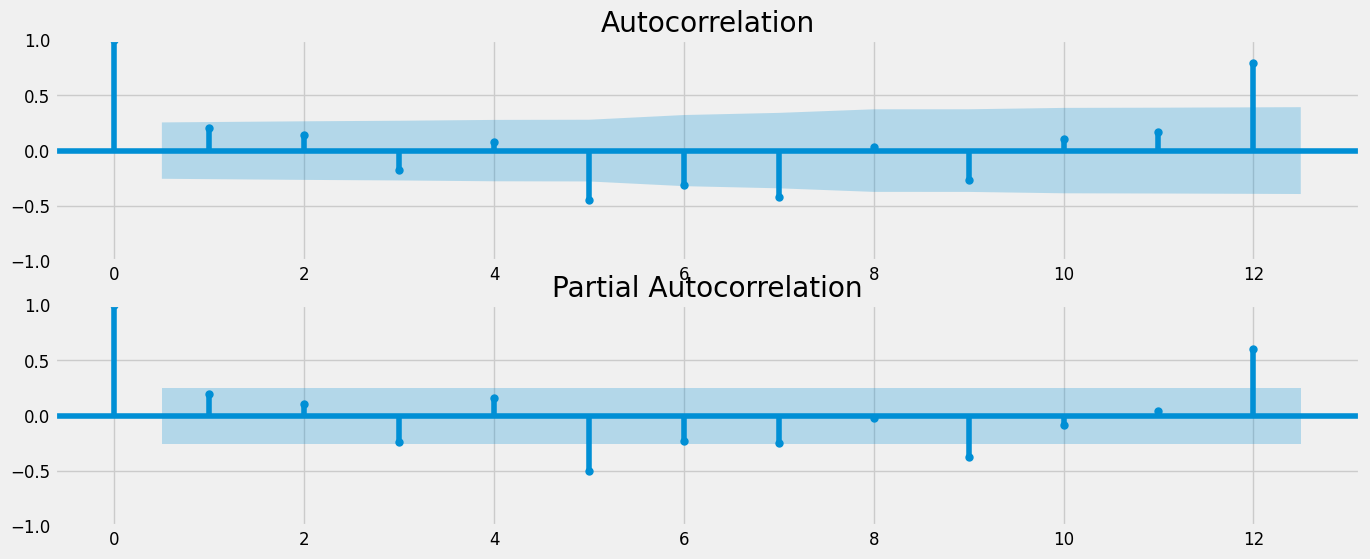

In [142]:
plt.figure(figsize=(15,6))
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca(), lags = 12)
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca(), lags = 12)
plt.show()

In [143]:
# fit model
model = AutoReg(ts_log_diff, 12, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  sales   No. Observations:                   59
Model:                    AutoReg(12)   Log Likelihood                 124.259
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Tue, 06 Aug 2024   AIC                           -220.518
Time:                        22:56:46   BIC                           -194.616
Sample:                    02-01-2014   HQIC                          -210.771
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.005      1.280      0.201      -0.004       0.017
sales.L1      -0.0550      0.066     -0.839      0.401      -0.184       0.074
sales.L2      -0.1394      0.064     -2.182      0.0

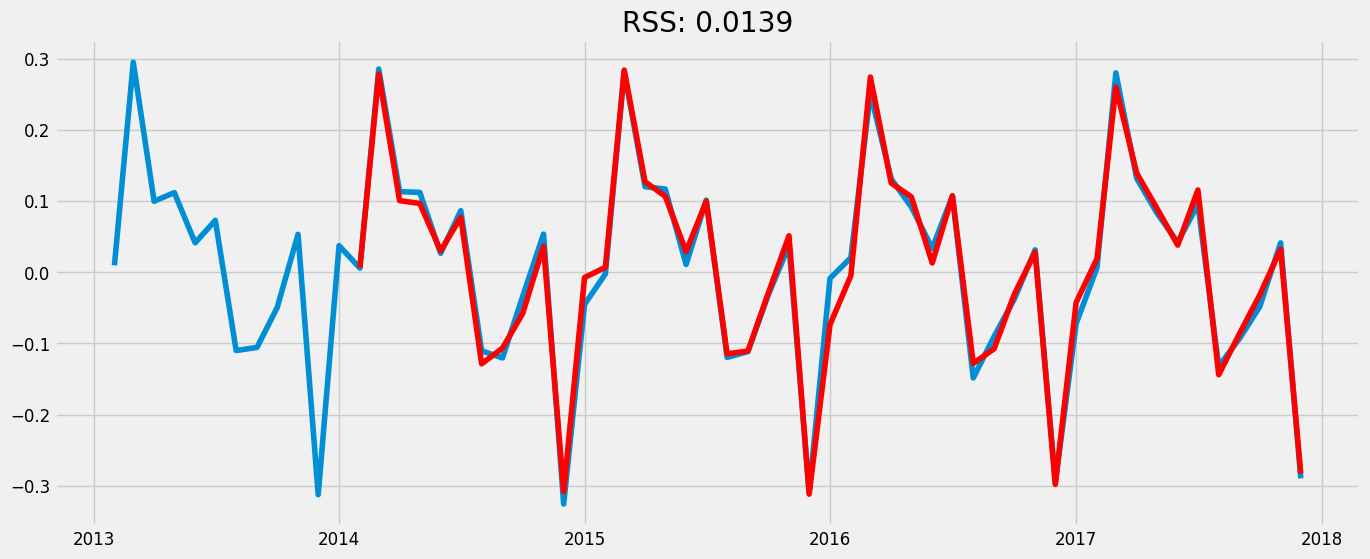

In [144]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Revirtiendo las transformaciones

__Valores ajustados o predichos:__

In [145]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

month_year
2014-02-01    0.006583
2014-03-01    0.278737
2014-04-01    0.100850
2014-05-01    0.096922
2014-06-01    0.030178
dtype: float64


__Suma acumulativa para revertir la diferenciación:__

In [146]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

month_year
2014-02-01    0.006583
2014-03-01    0.285320
2014-04-01    0.386170
2014-05-01    0.483092
2014-06-01    0.513270
dtype: float64


__Agregar el valor del primer mes que se eliminó previamente al diferenciar:__

In [147]:
predictions_ARIMA_diff_cumsum.head()

month_year
2014-02-01    0.006583
2014-03-01    0.285320
2014-04-01    0.386170
2014-05-01    0.483092
2014-06-01    0.513270
dtype: float64

In [148]:
predictions_ARIMA_log = pd.Series(ts_log.sales.iloc[0], index=ts_log.index)

In [149]:
predictions_ARIMA_log.head()

month_year
2013-01-01    13.027842
2013-02-01    13.027842
2013-03-01    13.027842
2013-04-01    13.027842
2013-05-01    13.027842
dtype: float64

In [150]:
predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

month_year
2013-01-01    13.027842
2013-02-01    13.027842
2013-03-01    13.027842
2013-04-01    13.027842
2013-05-01    13.027842
2013-06-01    13.027842
2013-07-01    13.027842
2013-08-01    13.027842
2013-09-01    13.027842
2013-10-01    13.027842
2013-11-01    13.027842
2013-12-01    13.027842
2014-01-01    13.027842
2014-02-01    13.034425
2014-03-01    13.313161
2014-04-01    13.414012
2014-05-01    13.510934
2014-06-01    13.541111
2014-07-01    13.618547
2014-08-01    13.489849
2014-09-01    13.383234
2014-10-01    13.325310
2014-11-01    13.361922
2014-12-01    13.053338
2015-01-01    13.046020
2015-02-01    13.053102
2015-03-01    13.337592
2015-04-01    13.464951
2015-05-01    13.571948
2015-06-01    13.601189
2015-07-01    13.701267
2015-08-01    13.586544
2015-09-01    13.475917
2015-10-01    13.446144
2015-11-01    13.497527
2015-12-01    13.185475
2016-01-01    13.111865
2016-02-01    13.107122
2016-03-01    13.381839
2016-04-01    13.507389
2016-05-01    13.613458
2016-

In [151]:
predictions_ARIMA_log = pd.Series(ts_log.sales.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

month_year
2013-01-01    13.027842
2013-02-01    13.027842
2013-03-01    13.027842
2013-04-01    13.027842
2013-05-01    13.027842
dtype: float64

__Tomando exponente para invertir la transformación del registro:__

In [152]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [153]:
predictions_ARIMA.head()

month_year
2013-01-01    454904.0
2013-02-01    454904.0
2013-03-01    454904.0
2013-04-01    454904.0
2013-05-01    454904.0
dtype: float64

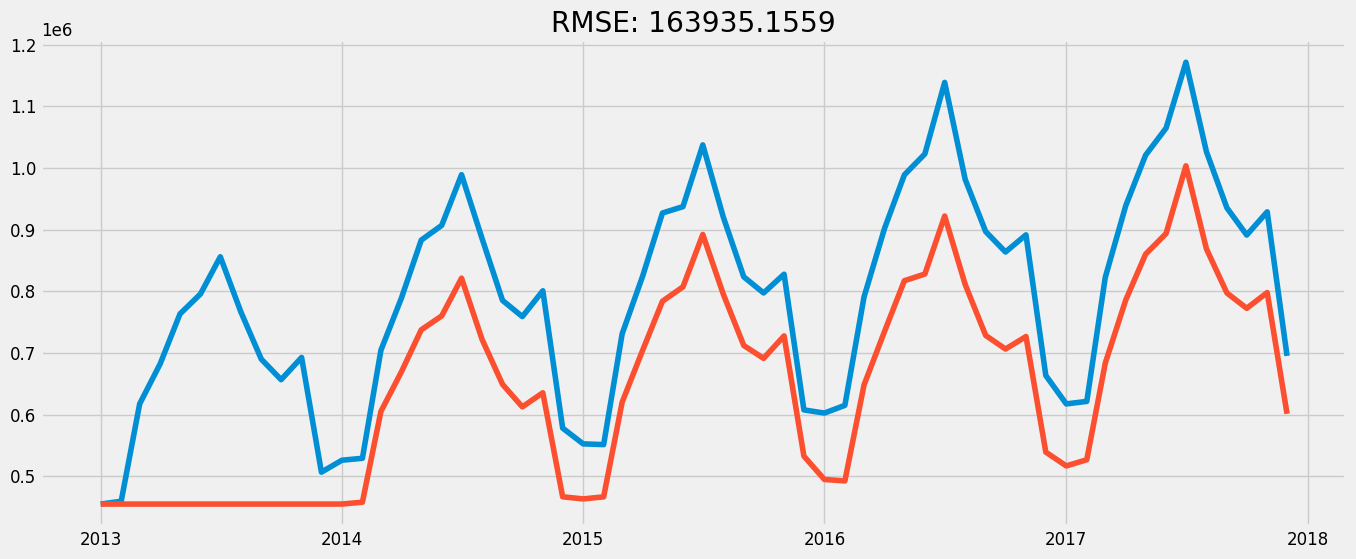

In [154]:
plt.figure(figsize=(15,6))
plt.plot(y_ventas_totales.sales)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y_ventas_totales.sales)**2)/len(y_ventas_totales.sales)))
plt.show()

### Métricas de puntuación de calidad de pronóstico
- __R-cuadrado__
- __Error absoluto medio__
- __Median Absolute Error__
- __Error medio cuadrado__
- __Error logarítmico medio cuadrado__
- __Error medio absoluto de porcentaje__

In [155]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R cuadrado__, coeficiente de determinación (puede interpretarse como un porcentaje de varianza explicado por el modelo), (-inf, 1]
- sklearn.metrics.r2_score

__Mean Absolute Error__, es una métrica interpretable porque tiene la misma unidad de medida que la serie inicial, [0, + inf)
- sklearn.metrics.mean_absolute_error

In [156]:
mean_absolute_error(y_ventas_totales.sales, predictions_ARIMA)

148369.68970991374

__Median Absolute Error__, nuevamente una métrica interpretable, particularmente interesante porque es robusta para los valores atípicos, [0, + inf)
- sklearn.metrics.median_absolute_error

In [157]:
median_absolute_error(y_ventas_totales.sales, predictions_ARIMA)

142913.62504615483

__Mean Squared Error__, más comúnmente usado, da una penalización mayor a los grandes errores y viceversa, [0, + inf)
- sklearn.metrics.mean_squared_error


In [158]:
mean_squared_error(y_ventas_totales.sales, predictions_ARIMA)

26874735342.85009

__Error logarítmico medio cuadrado__, prácticamente lo mismo que MSE pero inicialmente tomamos el logaritmo de la serie, como resultado también prestamos atención a pequeños errores, generalmente se usa cuando los datos tienen tendencias exponenciales, [0, + inf)

In [159]:
mean_squared_log_error(y_ventas_totales.sales, predictions_ARIMA)

0.05879582989707919

__Error medio porcentual absoluto__, igual que MAE pero porcentaje, - muy conveniente cuando desea explicar la calidad del modelo a su gerencia, [0, + inf),
- no implementado en sklearn

In [160]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [161]:
mean_absolute_percentage_error(y_ventas_totales.sales, predictions_ARIMA)

18.571838055061075

__Función para evaluar el pronóstico utilizando las métricas anteriores:__

In [162]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [163]:
evaluate_forecast(y_ventas_totales.sales, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.085793,148369.68971,142913.625046,2.687474e+10,0.058796,18.571838,163935.155909


- RMSE tiene el beneficio de penalizar más errores grandes, por lo que puede ser más apropiado en algunos casos.

- Desde el punto de vista de la interpretación, MAE es claramente el ganador. RMSE no describe solo el error promedio y tiene otras implicaciones que son más difíciles de descifrar y comprender.

- Por otro lado, una ventaja distintiva de RMSE sobre MAE es que RMSE evita el uso de tomar el valor absoluto, lo que no es deseable en muchos cálculos matemáticos.

## Media móvil (MA)

- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

In [164]:
# MA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

# fit model
model = ARIMA(ts_log_diff, order=(0, 0, 5))
model_fit = model.fit()

In [165]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   59
Model:                 ARIMA(0, 0, 5)   Log Likelihood                  45.935
Date:                Tue, 06 Aug 2024   AIC                            -77.869
Time:                        22:56:48   BIC                            -63.326
Sample:                    02-01-2013   HQIC                           -72.192
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.005      1.270      0.204      -0.003       0.016
ma.L1         -0.0511     40.800     -0.001      0.999     -80.017      79.915
ma.L2          0.1851      9.036      0.020      0.984     -17.525      17.895
ma.L3         -0.2159     20.761     -0.010      0.992     -40.907      40.476
ma.L4          0.0675     43.367      0.002      0.999     -84.930      85.065
ma.L5         -0.9737     51.308     -0.019      0.985    -101.535      99.588
sigma2         0.0102      0.536      0.019      0.985      -1.040       1.060
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.22   Prob(JB):                         0.75
Heteroskedasticity (H):               0.90   Skew:                            -0.03
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

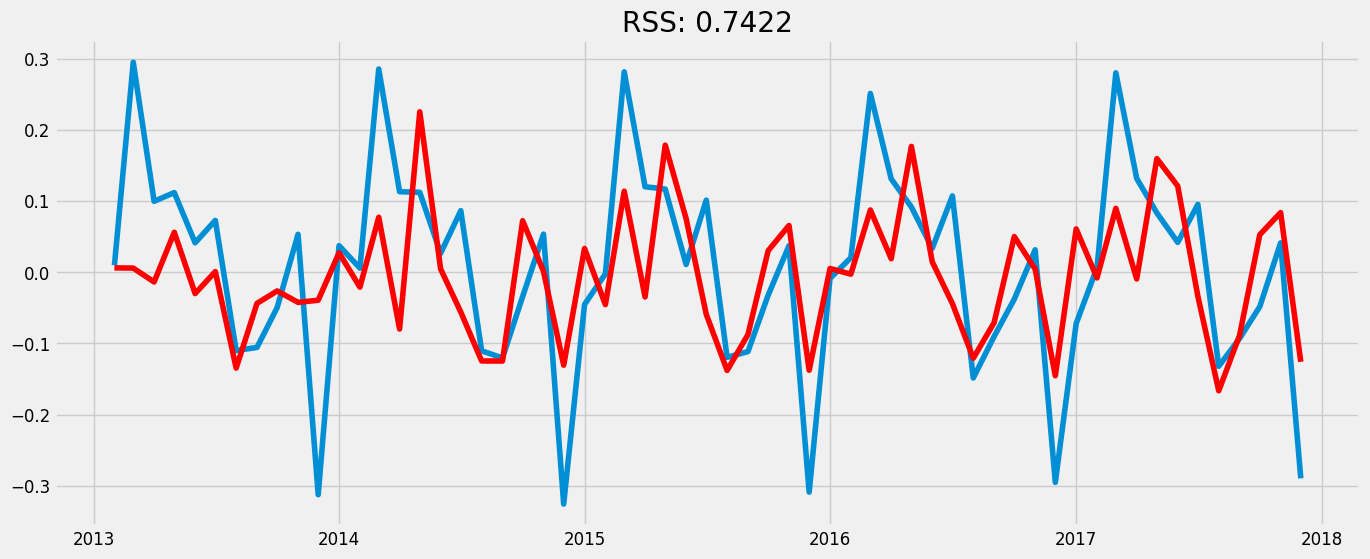

In [166]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Media móvil autorregresiva (ARMA)

- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).
- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.


In [167]:
# ARMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

# fit model
model = ARIMA(ts_log_diff, order=(12,0,5))
model_fit = model.fit()

In [168]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   59
Model:                ARIMA(12, 0, 5)   Log Likelihood                 116.586
Date:                Tue, 06 Aug 2024   AIC                           -195.172
Time:                        22:56:49   BIC                           -155.699
Sample:                    02-01-2013   HQIC                          -179.763
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.422      0.015       0.001       0.013
ar.L1         -0.0383      0.109     -0.352      0.725      -0.251       0.175
ar.L2          0.0173      0.100      0.173      0.863      -0.178       0.213
ar.L3         -0.0210      0.100     -0.210      0.834      -0.217       0.175
ar.L4         -0.0714      0.112     -0.640      0.522      -0.290       0.147
ar.L5          0.0383      0.108      0.355      0.723      -0.173       0.250
ar.L6         -0.0478      0.094     -0.510      0.610      -0.231       0.136
ar.L7         -0.0923      0.093     -0.989      0.323      -0.275       0.091
ar.L8          0.0506      0.095      0.531      0.596      -0.136       0.237
ar.L9         -0.0671      0.103     -0.653      0.514      -0.269       0.134
ar.L10        -0.0519      0.101     -0.514      0.608      -0.250       0.146
ar.L11         0.0122      0.099      0.123      0.902      -0.181       0.206
ar.L12         0.9314      0.092     10.140      0.000       0.751       1.111
ma.L1         -0.1205      0.258     -0.467      0.640      -0.626       0.385
ma.L2         -0.2455      0.277     -0.886      0.376      -0.789       0.298
ma.L3         -0.1587      0.200     -0.794      0.427      -0.550       0.233
ma.L4          0.3585      0.246      1.455      0.146      -0.124       0.841
ma.L5         -0.4404      0.370     -1.189      0.234      -1.166       0.285
sigma2         0.0006      0.000      3.636      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.45   Prob(JB):                         0.24
Heteroskedasticity (H):               0.88   Skew:                            -0.52
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

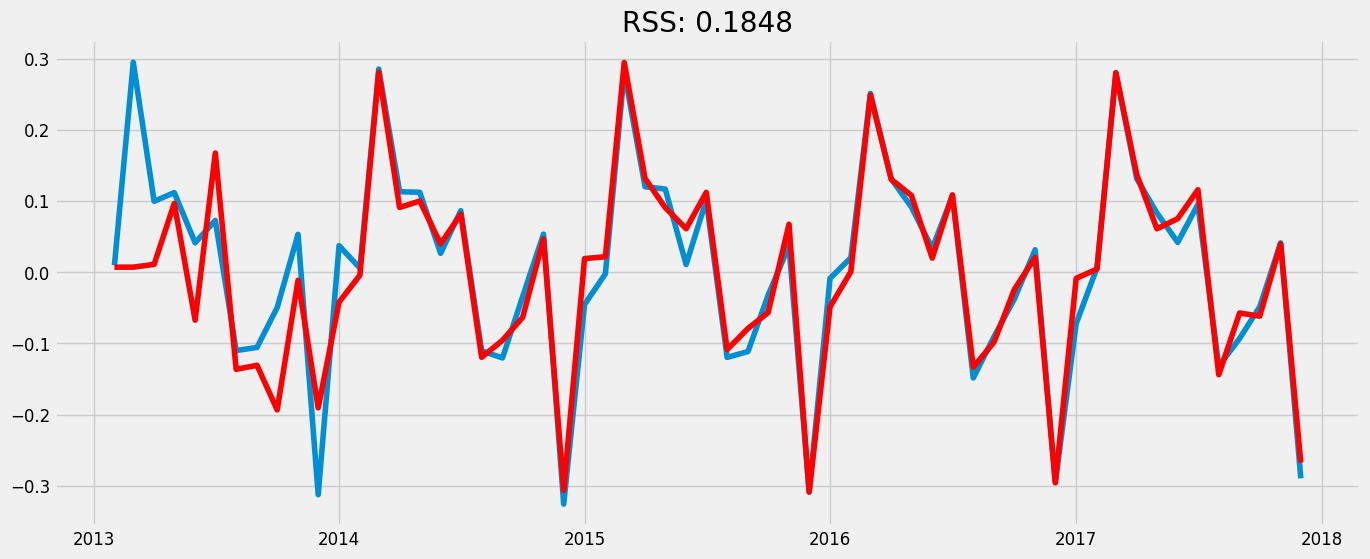

In [169]:
plt.figure(figsize=(15,6))
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Media móvil integrada autorregresiva (ARIMA)
En un modelo ARIMA hay 3 parámetros que se utilizan para ayudar a modelar los aspectos principales de una serie de tiempo: estacionalidad, tendencia y ruido. Estos parámetros están etiquetados como p, d y q.

- __Número de términos AR (Auto-regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).
- __Número de diferencias (d):__ d es el parámetro asociado con la parte integrada del modelo, que afecta la cantidad de diferencia que se aplica a una serie de tiempo.
- __Número de términos MA (promedio móvil) (q):__ q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

<br> __Observaciones de EDA en la serie temporal:__
- La no estacionariedad implica que se requiere al menos un nivel de diferencia (d) en ARIMA
- [El siguiente paso es seleccionar los valores de retraso para los parámetros de Autoregresión (AR) y Media móvil (MA), p y q respectivamente, utilizando gráficos PACF, ACF]

[Ajuste de los parámetros de ARIMA] (https://machinelearningmastery.com/tune-arima-parameters-python/)


Nota: Un problema con ARIMA es que no admite datos estacionales. Esa es una serie de tiempo con un ciclo repetitivo. ARIMA espera datos que no sean estacionales o que eliminen el componente estacional, p. ajustado estacionalmente mediante métodos como la diferenciación estacional.

In [170]:
ts = y_ventas_totales.sales - y_ventas_totales.sales.shift()
ts.dropna(inplace=True)

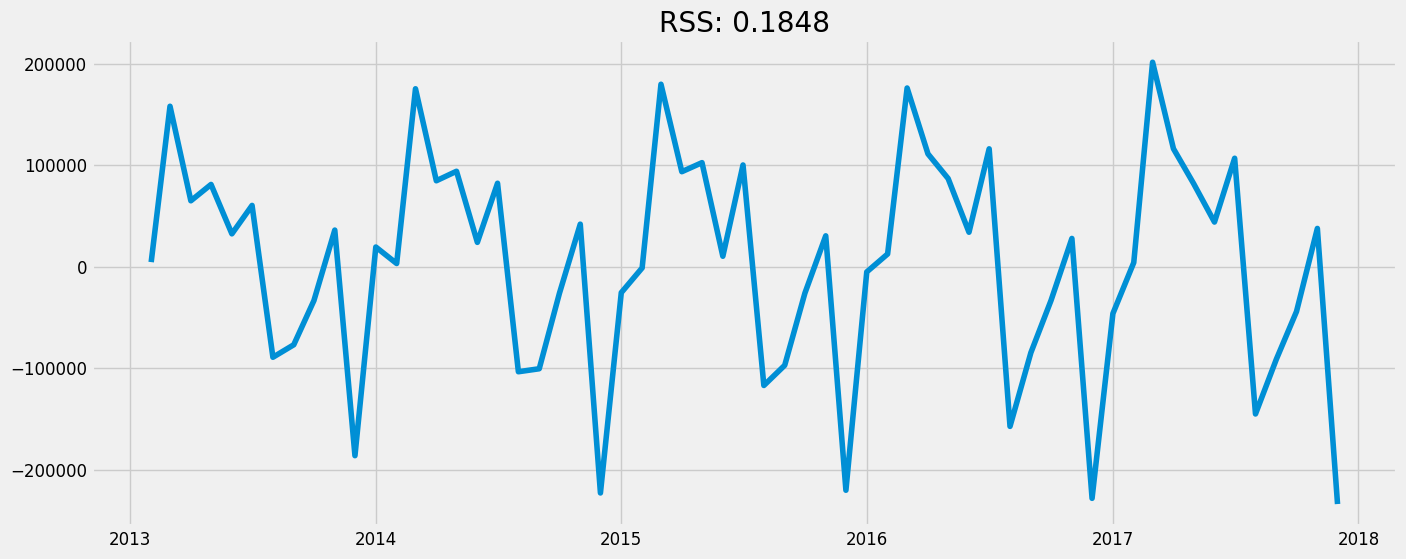

In [171]:
plt.figure(figsize=(15,6))
plt.plot(ts)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

__Gráficos ACF y PACF después de diferenciar:__
- Los intervalos de confianza se dibujan como un cono.
- De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
- Proceso AR (1): tiene un ACF que se reduce y el PACF se corta en el retraso = 1
- Proceso AR (2): tiene un ACF que se reduce y el PACF se corta en el retraso = 2
- Proceso MA (1): tiene un corte de ACF en el retraso = 1
- Proceso MA (2) - tiene un corte de ACF en el retraso = 2


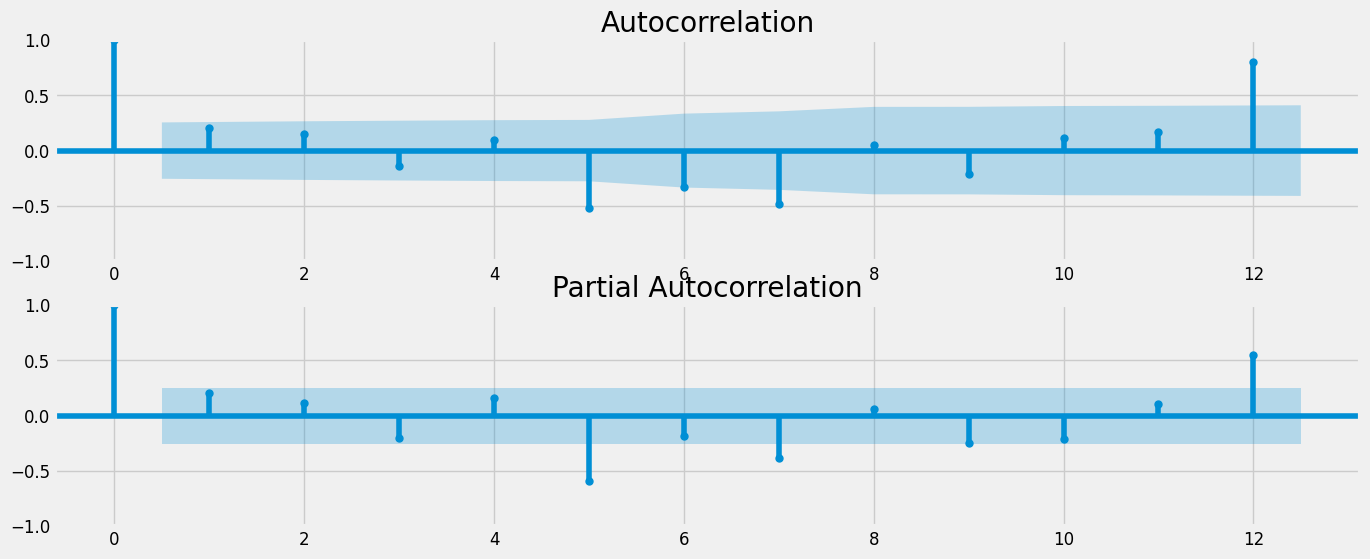

In [172]:
plt.figure(figsize=(15,6))
plt.subplot(211)
plot_acf(ts, ax=plt.gca(),lags=12)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(),lags=12)
plt.show()

## Interpretando diagramas ACF


ACF Shape | Modelo indicado |
- | - |
Exponencial, decayendo a cero | Modelo autorregresivo. Utilice el gráfico de autocorrelación parcial para identificar el orden del modelo autorregresivo |
Alternancia positiva y negativa, decayendo a cero Modelo autorregresivo.  | Use el gráfico de autocorrelación parcial para ayudar a identificar el orden. |
Uno o más picos, el resto son esencialmente cero | Modelo de media móvil, orden identificado por donde la trama se convierte en cero.  |
Decaimiento, comenzando después de algunos retrasos | Modelo mixto autorregresivo y de media móvil (ARMA). |
Todo cero o cerca de cero | Los datos son esencialmente aleatorios.  |
Valores altos a intervalos fijos | Incluye término estacional autorregresivo.  |
Sin descomposición a cero | La serie no es estacionaria |

<Axes: xlabel='month_year'>

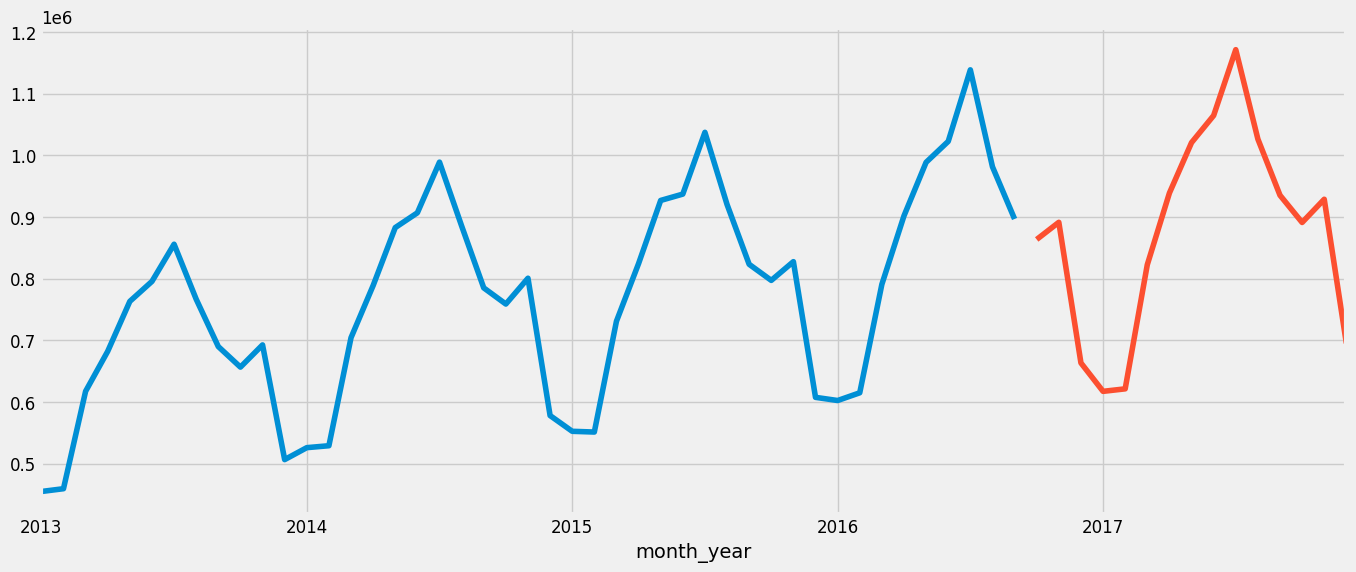

In [173]:
#divide into train and validation set
train = y_ventas_totales[:int(0.75*(len(y_ventas_totales)))]
valid = y_ventas_totales[int(0.75*(len(y_ventas_totales))):]

#plotting the data
plt.figure(figsize=(15,6))
train['sales'].plot()
valid['sales'].plot()

### Auto ARIMA

In [174]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1153.104, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1213.496, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1169.233, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1190.908, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1351.380, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1164.527, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1169.103, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1150.490, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1151.816, Time=0.19 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1152.062, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1145.691, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1158.101, Time=0.17 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1146.291, Time=0.27 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=1137.311, Time=0.31 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept

ARIMA(order=(3, 0, 4), scoring_args={}, suppress_warnings=True)

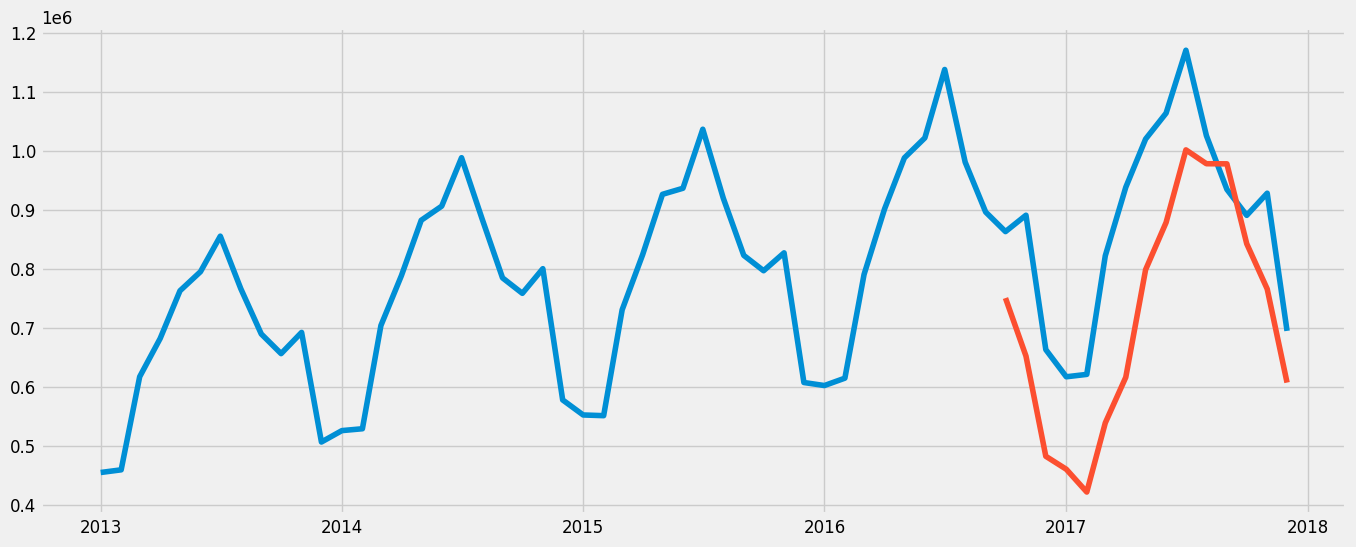

In [175]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

plt.figure(figsize=(15,6))
#plot the predictions for validation set
plt.plot(y_ventas_totales.sales, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [176]:
evaluate_forecast(valid.sales, forecast.Prediction)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.293574,164061.993264,169094.312949,3.361184e+10,0.066259,19.458653,183335.315093


## Promedio móvil integrado estacional autorregresivo (SARIMA)
El promedio móvil integrado estacional autorregresivo, SARIMA o ARIMA estacional, es una extensión de ARIMA que admite explícitamente datos de series temporales univariantes con un componente estacional.

Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), la diferenciación (I) y el promedio móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de estacionalidad.

__Elementos de tendencia:__

Hay tres elementos de tendencia que requieren configuración. Son los mismos que el modelo ARIMA, específicamente:

- p: orden de tendencia de autorregresión.
- d: orden de diferencia de tendencia.
- q: tendencia de la media móvil.

__Elementos estacionales:__

Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; son:

- P: orden autorregresivo estacional.
- D: orden de diferencia estacional.
- Q: orden de media móvil estacional.
- m: el número de pasos de tiempo para un solo período estacional. Por ejemplo, una S de 12 para datos mensuales sugiere un ciclo estacional anual.

__Notación SARIMA:__
SARIMA (p, d, q) (P, D, Q, m)

In [177]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(2, 1, 5), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

In [178]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [179]:
# report performance
mse = mean_squared_error(y_ventas_totales[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 43424.288286924944, MSE:1885668813.225967


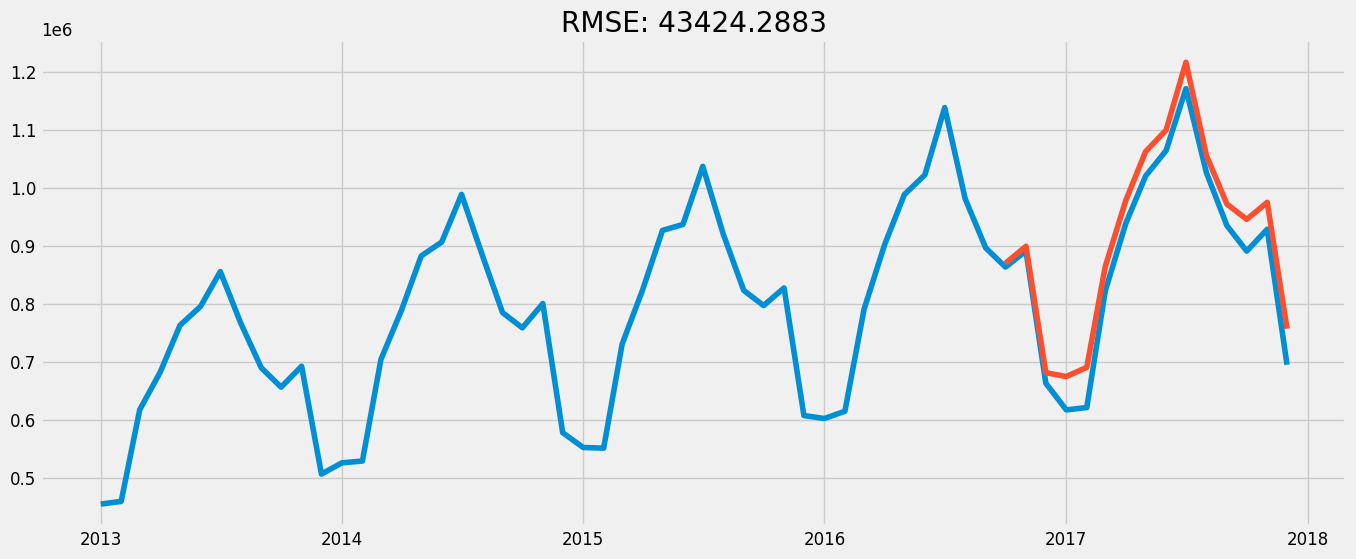

In [180]:
plt.figure(figsize=(15,6))
plt.plot(y_ventas_totales)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [181]:
evaluate_forecast(y_ventas_totales.loc[start_index:end_index,'sales'], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.927429,39641.649349,42066.77238,1.885669e+09,0.002932,4.83395,43424.288287


### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [182]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12, stepwise=True)
model.fit(train)
model_fit=model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=730.539, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=782.298, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=804.384, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=769.754, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=838.075, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=741.850, Time=0.66 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=730.997, Time=1.13 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=732.651, Time=1.07 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=734.470, Time=1.09 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=732.766, Time=1.51 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=731.81

In [183]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

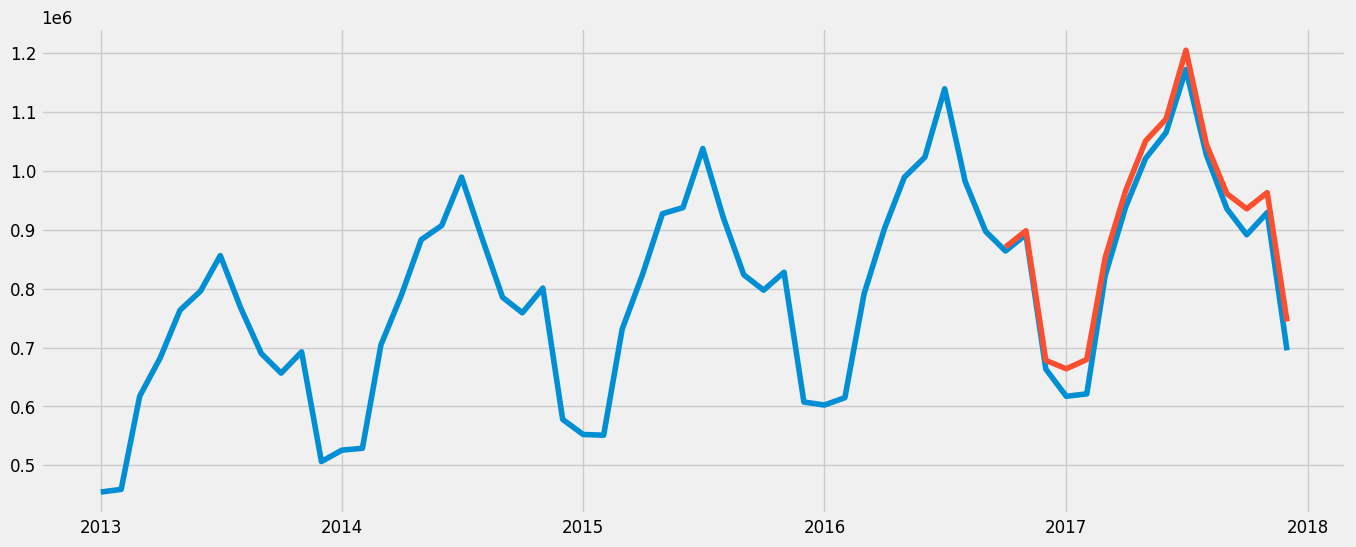

In [205]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

plt.figure(figsize=(15,6))
#plot the predictions for validation set
plt.plot(y_ventas_totales.sales, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [206]:
evaluate_forecast(y_ventas_totales.loc[start_index:end_index,'sales'], forecast.Prediction)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.957647,29786.316928,29632.808445,1.100492e+09,0.001827,3.685949,33173.659876


__Diagnóstico del modelo:__
- Nuestra principal preocupación es garantizar que los residuos de nuestro modelo no estén correlacionados y normalmente se distribuyan con media cero.
- Si el modelo estacional ARIMA no satisface estas propiedades, es una buena indicación de que puede mejorarse aún más.

El diagnóstico del modelo sugiere que el modelo residual se distribuye normalmente en función de lo siguiente:

- En la gráfica superior derecha, la línea roja de KDE sigue de cerca con la línea N (0,1). Donde, N (0,1) es la notación estándar para una distribución normal con media 0 y desviación estándar de 1. Esta es una buena indicación de que los residuos se distribuyen normalmente.
- La gráfica qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar. Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.
- Los residuos a lo largo del tiempo (gráfico superior izquierdo) no muestran ninguna estacionalidad obvia y parecen ser ruido blanco.
- Esto se confirma mediante el gráfico de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de series temporales tienen una baja correlación con versiones rezagadas de sí mismo.

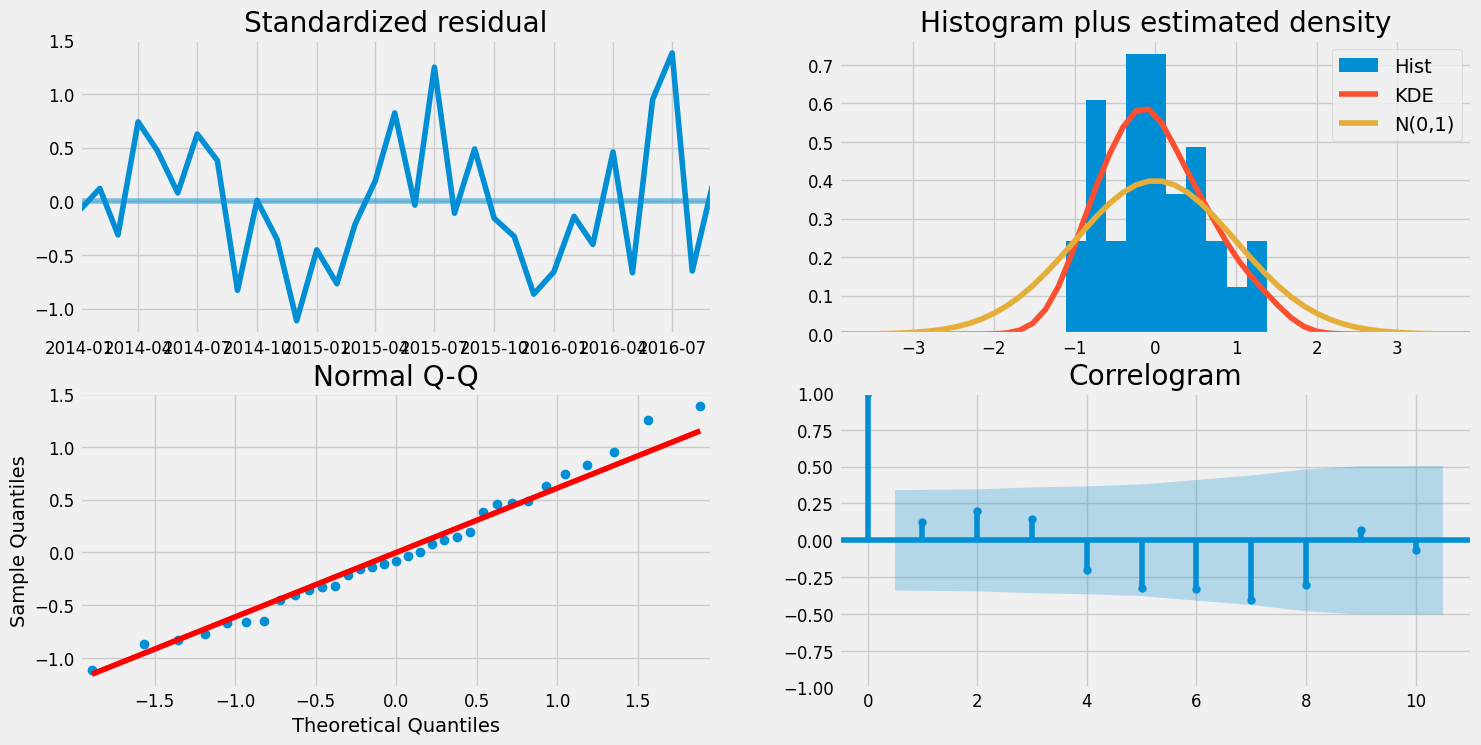

In [207]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [208]:
y_forecasted = forecast.Prediction
y_truth = y_ventas_totales[start_index:end_index].sales.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1100491709.55


In [209]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33173.66
